The following report conducts a GTFS analysis on Bay Area Rapid Transit (BART) effective on May/26/2018.<br>
The report is written by Haoran Su, under supervision of and guidance by Professor Kenichi Soga, Gerard Casey and Krishna Kumar<br>
University of California at Berkeley<br>
University of Cambridge<br>

# General Transit Feed Specification (GTFS) on BART system

In [536]:
# Modules necessary for this project
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from bokeh.plotting import figure, show
from bokeh.resources import CDN
from bokeh.io import output_notebook
import time
import datetime
import warnings
warnings.filterwarnings("ignore")

In [537]:
# Read the following csv files
trips = pd.read_csv('trips.txt')
st = pd.read_csv('stop_times.txt')
routes = pd.read_csv('routes.txt')
stops = pd.read_csv('stops.txt')
stop_times = pd.read_csv('stop_times.txt')

In [538]:
# Take a look at the trips
trips.head(5)

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed
0,1,WKDY,3610403WKDY,San Francisco International Airport,0,NaN,01_shp,1,1
1,1,SAT,3730559SAT,Millbrae,0,NaN,01_shp,1,1
2,1,SUN,3650800SUN,Millbrae,0,NaN,01_shp,1,1
3,1,WKDY,3630418WKDY,San Francisco International Airport,0,NaN,01_shp,1,1
4,1,SAT,3750558SAT,Millbrae,0,NaN,01_shp,1,1


What we would like to notice is that trip_id is the unique key in the database to identify the trip.

In [539]:
# We could tell how many trips we will be conducting analysis on:
trips.size

22725

In [540]:
# Then we could take a look at the stop times dataframe:
stop_times.head(5)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint
0,3650800SUN,08:00:00,08:00:00,LAFY,1,Millbrae,NaN,NaN,NaN,1
1,3650800SUN,08:05:00,08:05:00,ORIN,2,Millbrae,NaN,NaN,NaN,1
2,3650800SUN,08:11:00,08:11:00,ROCK,3,Millbrae,NaN,NaN,NaN,1
3,3650800SUN,08:15:00,08:15:00,MCAR_S,4,Millbrae,NaN,NaN,NaN,1
4,3650800SUN,08:18:00,08:18:00,19TH,5,Millbrae,NaN,NaN,NaN,1


According to GTFS Reference(https://developers.google.com/transit/gtfs/reference/?csw=1#stop_timestxt), the arrival times measure the timepoint when the train stops at the certain station. <br>
The departure time would be identical to the arrival time if not stated.

In [541]:
# Then we could use merge to assign the all arrival_time/depart_time to each stop, stop_id to the unique foreign key
# of trip_id
trips_stoptimes = pd.merge(trips,st[['trip_id','stop_id','arrival_time']])
trips_stoptimes.head(10)

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed,stop_id,arrival_time
0,1,WKDY,3610403WKDY,San Francisco International Airport,0,NaN,01_shp,1,1,ANTC,03:49:00
1,1,WKDY,3610403WKDY,San Francisco International Airport,0,NaN,01_shp,1,1,PCTR,03:56:00
2,1,WKDY,3610403WKDY,San Francisco International Airport,0,NaN,01_shp,1,1,PITT,04:03:00
3,1,WKDY,3610403WKDY,San Francisco International Airport,0,NaN,01_shp,1,1,NCON,04:09:00
4,1,WKDY,3610403WKDY,San Francisco International Airport,0,NaN,01_shp,1,1,CONC,04:13:00
5,1,WKDY,3610403WKDY,San Francisco International Airport,0,NaN,01_shp,1,1,PHIL,04:18:00
6,1,WKDY,3610403WKDY,San Francisco International Airport,0,NaN,01_shp,1,1,WCRK,04:21:00
7,1,WKDY,3610403WKDY,San Francisco International Airport,0,NaN,01_shp,1,1,LAFY,04:25:00
8,1,WKDY,3610403WKDY,San Francisco International Airport,0,NaN,01_shp,1,1,ORIN,04:30:00
9,1,WKDY,3610403WKDY,San Francisco International Airport,0,NaN,01_shp,1,1,ROCK,04:36:00


Looks good as we successfully link all arrival_time and stop_id to each trip_id. 

In [542]:
# We could do a further merge to include the stop_name as well:
main = pd.merge(trips_stoptimes,stops[['stop_id','stop_name']])
main.head(5)

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed,stop_id,arrival_time,stop_name
0,1,WKDY,3610403WKDY,San Francisco International Airport,0,NaN,01_shp,1,1,ANTC,03:49:00,Antioch
1,1,WKDY,3630418WKDY,San Francisco International Airport,0,NaN,01_shp,1,1,ANTC,04:04:00,Antioch
2,1,SAT,3750558SAT,Millbrae,0,NaN,01_shp,1,1,ANTC,05:43:00,Antioch
3,1,SUN,3670758SUN,Millbrae,0,NaN,01_shp,1,1,ANTC,07:43:00,Antioch
4,1,WKDY,3650433WKDY,San Francisco International Airport,0,NaN,01_shp,1,1,ANTC,04:19:00,Antioch


And we would set this dataframe in this analysis.

# Trip Patterns

We could identify certain trip patterns given the main dataframe.

In [543]:
# We could know how many trips happened during the interval effective on 05/26/2018
trips['trip_id'].unique().size

2525

# Constructing a geographic map of the BART system

We could use networkx to draw a geographic map as a practice of network graph.<br>
The reference and manual of networkx could be found here:<br>
https://networkx.github.io/documentation/networkx-1.10/index.html

In [544]:
# Initialize a graph
geomap = nx.Graph()
# Enumerate all stops in the system:
unique_stops = main.stop_id.unique()
unique_stops

array(['ANTC', 'PCTR', 'PITT', 'NCON', 'CONC', 'PHIL', 'WCRK', 'LAFY',
       'ORIN', 'ROCK', 'MCAR_S', '19TH', '12TH', 'WOAK', 'EMBR', 'MONT',
       'POWL', 'CIVC', '16TH', '24TH', 'GLEN', 'BALB', 'DALY', 'COLM',
       'SSAN', 'SBRN', 'SFIA', 'MLBR', 'DUBL', 'WDUB', 'CAST', 'BAYF',
       'SANL', 'COLS', 'FTVL', 'LAKE', 'OAKL', '19TH_N', 'MCAR', 'FRMT',
       'UCTY', 'SHAY', 'HAYW', 'ASHB', 'DBRK', 'NBRK', 'PLZA', 'DELN',
       'RICH', 'WARM'], dtype=object)

In [545]:
# Add all of them as node, including their longitude and latitude, which could be found in stops.txt:
geomap.add_nodes_from(unique_stops)
# create a dictionary of node coordinates
nodes = dict(geomap.nodes)
for stop in nodes:
    lon = float(stops[stops['stop_id'] == stop]['stop_lon'])
    lat = float(stops[stops['stop_id'] == stop]['stop_lat'])
    nodes[stop] = (lon,lat)

In [546]:
# Extract all unique routes in the system
route_ids = routes.route_id.unique()
# Initialize an empty edge list
edge_list = []
# Iterate through all route
for route_id in route_ids:
    # pick one trip (the first one for example)
    trip_id = trips[trips.route_id == route_id]['trip_id'].iloc[0]
    # extract the stop lists for this trip id from stop_times
    stop_list = list(stop_times[stop_times.trip_id == trip_id]['stop_id'])
    # for each list, generate the pairs of edges and append them to edge_list
    for i in range(0,len(stop_list)-1):
        edge_tuple = (stop_list[i],stop_list[i+1])
        if edge_tuple not in edge_list:
            edge_list.append(edge_tuple)

In [547]:
# Add all edges to the graph:
geomap.add_edges_from(edge_list)

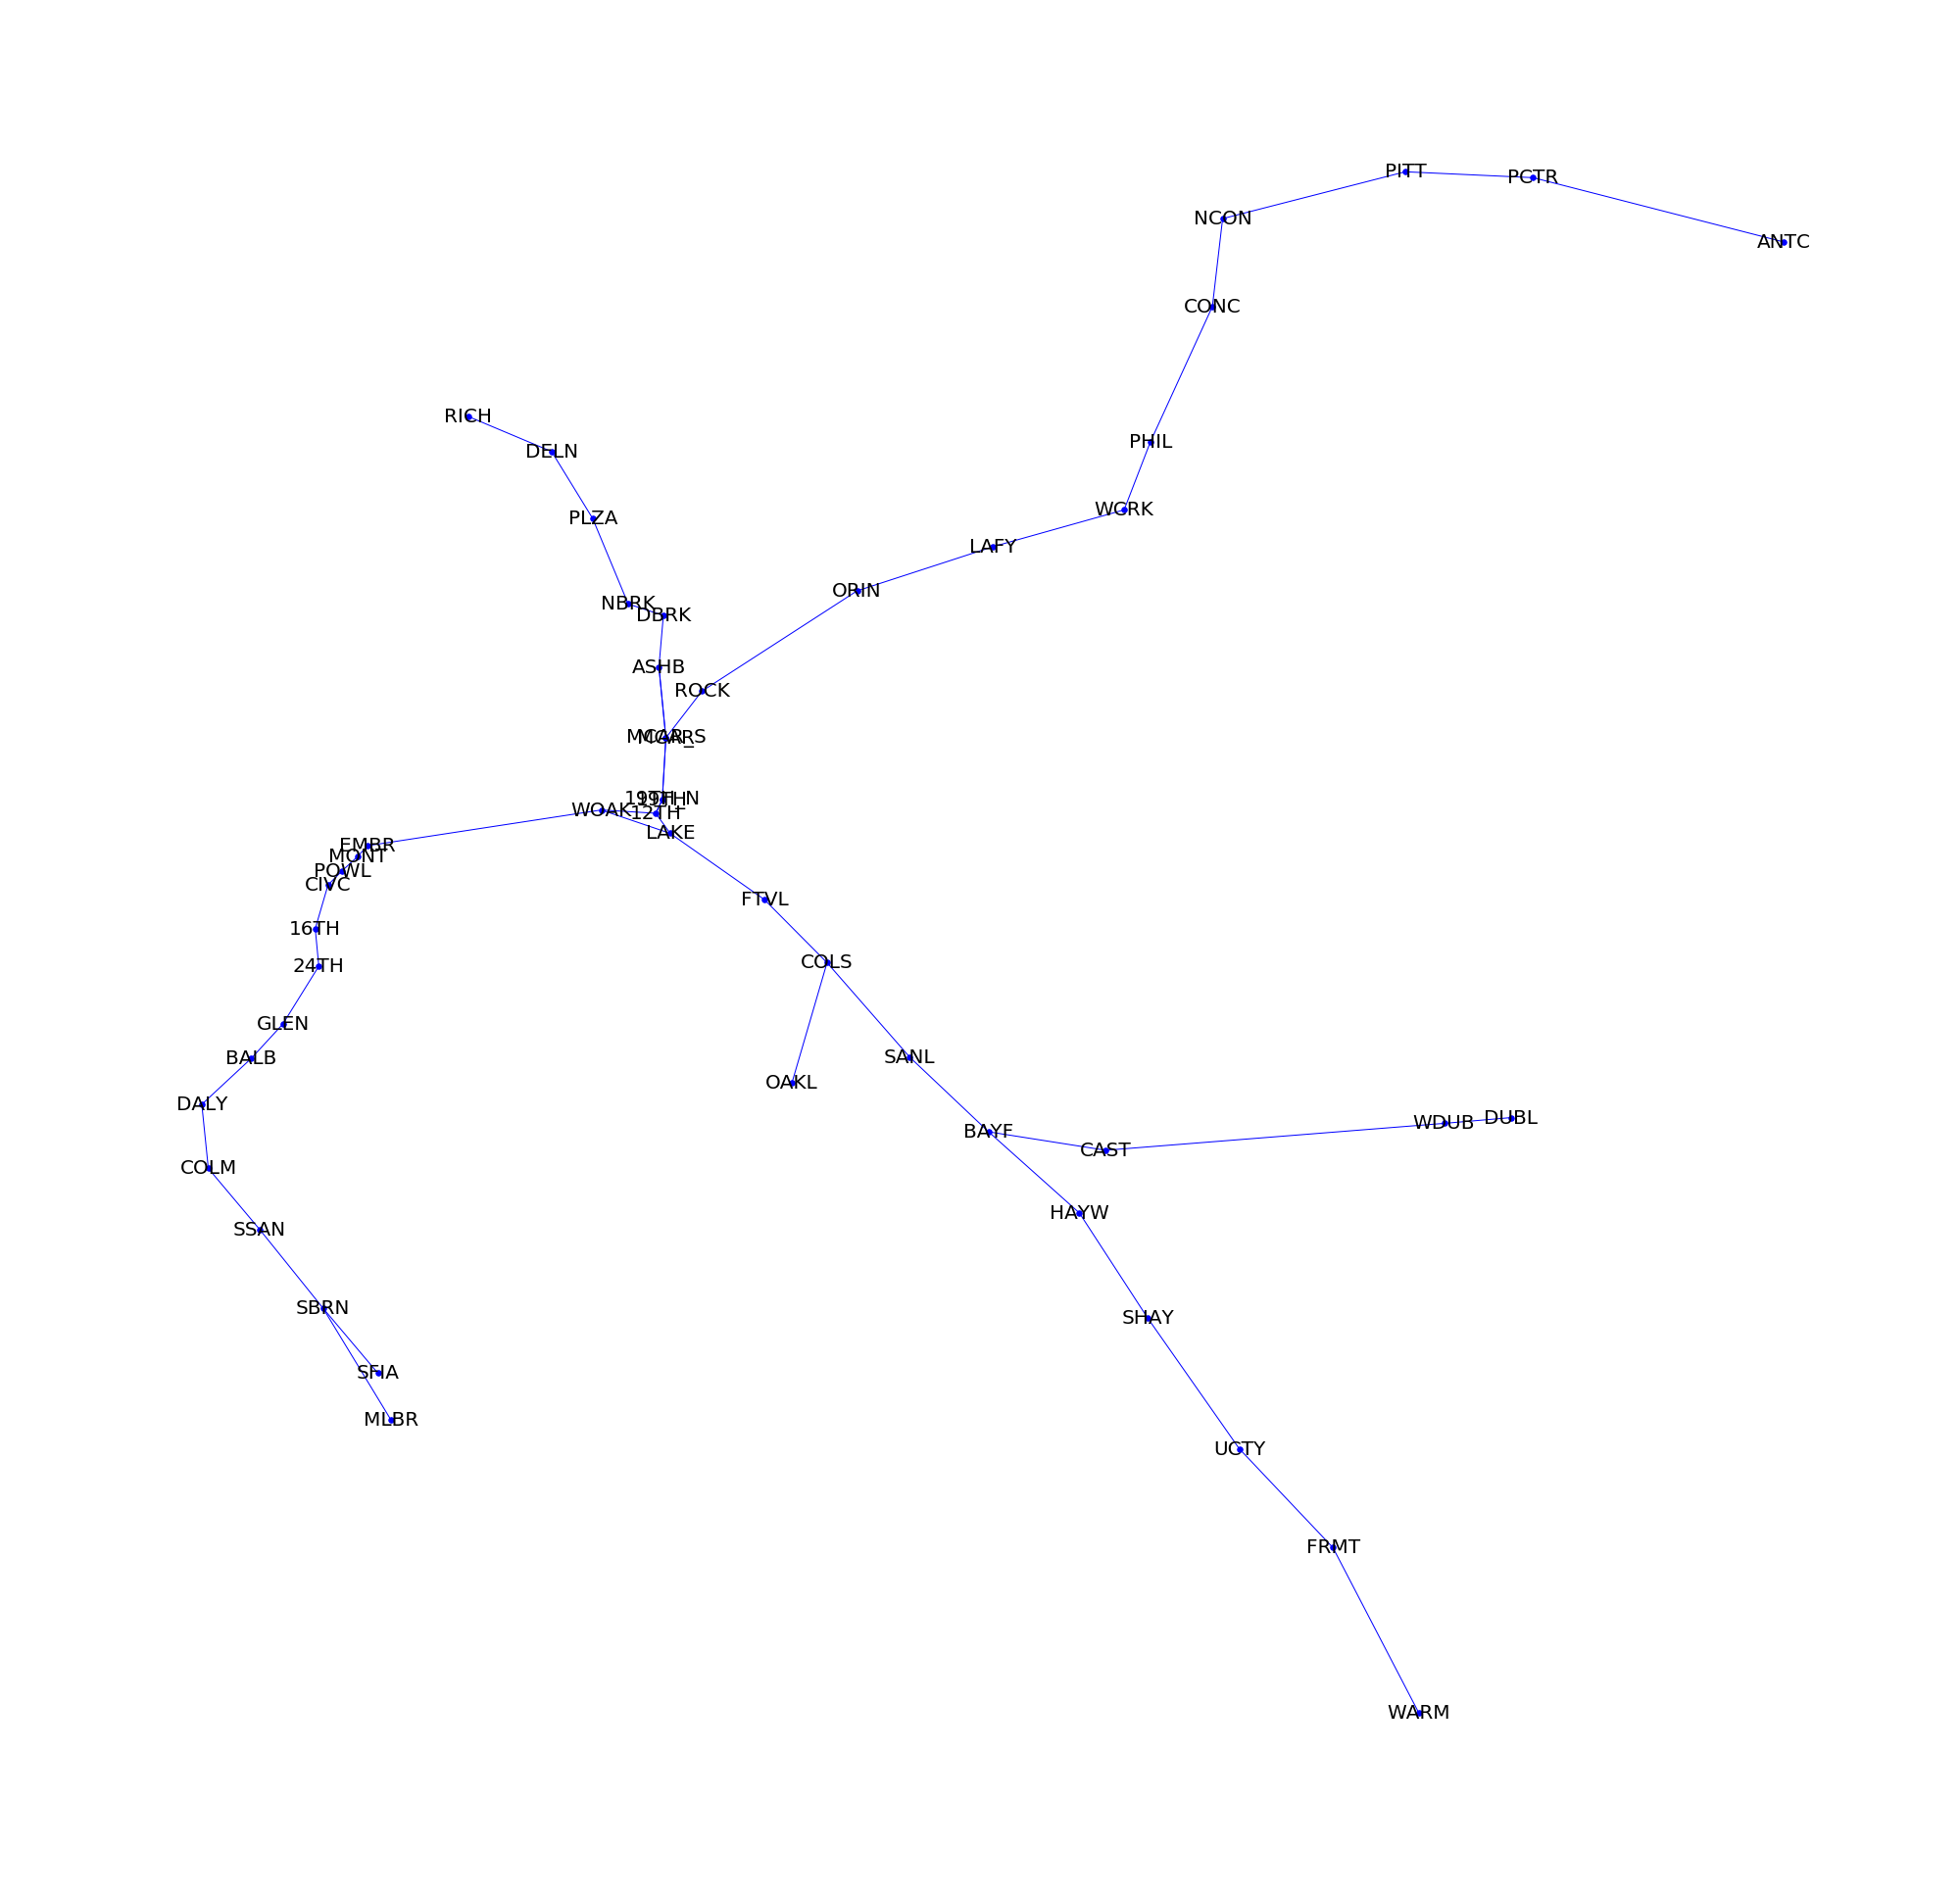

In [548]:
# Then we could plot this geographic map representing all the stops and route
fig = plt.figure()
nx.draw_networkx(geomap, pos = nodes , node_size = 30, node_color = 'b', font_size = 20, edge_color='b', style='solid')
plt.axis('off')
# Adjust the size so it could be fit in:
fig.set_size_inches(35, 35)
plt.show()

# PageRank on all stops

Based on the introduction of PageRank from networkx,<br>
https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.al gorithms.link_analysis.pagerank_alg.pagerank.html: <br>
"PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links. ", meaning that PageRank is a measure of importance of nodes in the network<br>

The idea of using PageRank and the following concept of hits are inspired by the website:<br>
http://markdunne.github.io/2016/04/10/The-London-Tube-as-a-Graph/

In [549]:
# Initialize the pagerank numpy for the given network structure and changed the default value to be 0.9
pagerank = nx.pagerank_numpy(geomap, alpha = 0.9)
# Initialize a series to store all the pagerank
series = pd.Series(pagerank, name='PageRank')
# Reset the index name to be stop_id
series.index.name = 'stop_id'
pagerank = series.reset_index()
pagerank.head(10)

,stop_id,PageRank
0,12TH,0.031955
1,16TH,0.019720
2,19TH,0.016853
3,19TH_N,0.017041
4,24TH,0.019896
5,ANTC,0.012266
6,ASHB,0.025930
7,BALB,0.020215
8,BAYF,0.028625
9,CAST,0.020406


In [550]:
# And we append the PageRank column to the stops table and we sort them according to their pagerank
stops = pd.merge(stops, pagerank)
stops.sort_values('PageRank', ascending=False).head(10)

,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,PageRank
40,SBRN,San Bruno,NaN,37.637761,-122.416287,SBRN,http://www.bart.gov/stations/SBRN/,0,NaN,NaN,1,0.032920
0,12TH,12th St. Oakland City Center,NaN,37.803768,-122.271450,12TH,http://www.bart.gov/stations/12TH/,0,NaN,NaN,1,0.031955
8,BAYF,Bay Fair,NaN,37.696924,-122.126514,BAYF,http://www.bart.gov/stations/BAYF/,0,NaN,NaN,1,0.028625
11,COLS,Coliseum,NaN,37.753661,-122.196869,COLS,http://www.bart.gov/stations/COLS/,0,NaN,NaN,1,0.027764
6,ASHB,Ashby,NaN,37.852803,-122.270062,ASHB,http://www.bart.gov/stations/ASHB/,0,NaN,NaN,1,0.025930
27,MCAR_S,MacArthur,NaN,37.829065,-122.267040,MCAR,http://www.bart.gov/stations/MCAR/,0,NaN,NaN,1,0.025543
49,WOAK,West Oakland,NaN,37.804872,-122.295140,WOAK,http://www.bart.gov/stations/WOAK/,0,NaN,NaN,1,0.024510
25,LAKE,Lake Merritt,NaN,37.797027,-122.265180,LAKE,http://www.bart.gov/stations/LAKE/,0,NaN,NaN,1,0.024498
35,PCTR,Pittsburg Center,NaN,38.016941,-121.889457,PCTR,http://www.bart.gov/stations/PCTR/,0,NaN,NaN,1,0.022813
20,FRMT,Fremont,NaN,37.557465,-121.976608,FRMT,http://www.bart.gov/stations/FRMT/,0,NaN,NaN,1,0.022586


In [551]:
# We could also generate the google matrix of the geo-graph
google_m = nx.google_matrix(geomap)
google_m

matrix([[ 0.003,  0.853,  0.003, ...,  0.003,  0.003,  0.003],
        [ 0.428,  0.003,  0.428, ...,  0.003,  0.003,  0.003],
        [ 0.003,  0.428,  0.003, ...,  0.003,  0.003,  0.003],
        ..., 
        [ 0.003,  0.003,  0.003, ...,  0.003,  0.428,  0.003],
        [ 0.003,  0.003,  0.003, ...,  0.853,  0.003,  0.003],
        [ 0.003,  0.003,  0.003, ...,  0.003,  0.003,  0.003]])

# HITS on all stops

Another link analysis concept could be computed on the node is called HITS. <br>
According to HITS Alogrithm, https://networkx.github.io/documentation/latest/reference/algorithms/generated/networkx.algorithms.link_analysis.hits_alg.hits_scipy.html#networkx.algorithms.link_analysis.hits_alg.hits_scipy<br>
"The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links."

In [552]:
# Compute the authorities and hubs for each stops, we raise the max_iter to 10 times of the default value for accuracy
# We also normalize the results so we could compare between stops
authorities, hubs = nx.hits_scipy(geomap, max_iter=1000,tol=1e-06, normalized=True)

auth_series = pd.Series(authorities, name='authorities')
hubs_series = pd.Series(hubs, name='hubs')
# Reset the index name to be stop_id
auth_series.index.name = 'stop_id'
hubs_series.index.name = 'stop_id'
authorities = auth_series.reset_index()
hubs = hubs_series.reset_index()

In [553]:
# Merge both indicators to the stops
stops = pd.merge(pd.merge(stops, authorities),hubs)
stops.head(5)
# Sort them by the value of authorities and hubs' value
stops.sort_values('authorities', ascending=False).head(10)
stops.sort_values('hubs', ascending=False).head(10)

,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,PageRank,authorities,hubs
0,12TH,12th St. Oakland City Center,NaN,37.803768,-122.271450,12TH,http://www.bart.gov/stations/12TH/,0,NaN,NaN,1,0.031955,0.147022,0.147022
25,LAKE,Lake Merritt,NaN,37.797027,-122.265180,LAKE,http://www.bart.gov/stations/LAKE/,0,NaN,NaN,1,0.024498,0.122794,0.122794
49,WOAK,West Oakland,NaN,37.804872,-122.295140,WOAK,http://www.bart.gov/stations/WOAK/,0,NaN,NaN,1,0.024510,0.121977,0.121977
2,19TH,19th St. Oakland,NaN,37.808350,-122.268602,19TH,http://www.bart.gov/stations/19TH/,0,NaN,NaN,1,0.016853,0.075458,0.075458
3,19TH_N,19th St. Oakland,NaN,37.808350,-122.268602,19TH,http://www.bart.gov/stations/19TH/,0,NaN,NaN,1,0.017041,0.071454,0.071454
21,FTVL,Fruitvale,NaN,37.774836,-122.224175,FTVL,http://www.bart.gov/stations/FTVL/,0,NaN,NaN,1,0.017679,0.058136,0.058136
19,EMBR,Embarcadero,NaN,37.792874,-122.397020,EMBR,http://www.bart.gov/stations/EMBR/,0,NaN,NaN,1,0.017713,0.055142,0.055142
27,MCAR_S,MacArthur,NaN,37.829065,-122.267040,MCAR,http://www.bart.gov/stations/MCAR/,0,NaN,NaN,1,0.025543,0.054006,0.054006
6,ASHB,Ashby,NaN,37.852803,-122.270062,ASHB,http://www.bart.gov/stations/ASHB/,0,NaN,NaN,1,0.025930,0.044004,0.044004
26,MCAR,MacArthur,NaN,37.829065,-122.267040,MCAR,http://www.bart.gov/stations/MCAR/,0,NaN,NaN,1,0.017447,0.043339,0.043338


Then we could viusalize the graph with the authorities and hubs we obtained.<br>
<b>The following cell of code is adopted then modified from the following website as a graphic tool to find out the most important stations in the system</b>:<br>
http://markdunne.github.io/2016/04/10/The-London-Tube-as-a-Graph/<br>
In[13] and In[14]

In [554]:
import colorsys
def pseudocolor(val):
    h = (1.0 - val) * 120 / 360
    r, g, b = colorsys.hsv_to_rgb(h, 1., 1.)
    return r * 255, g * 255, b * 255

# Comment out one of the next two lines to see different results
# normed = stops[['stop_lon', 'stop_lat', 'PageRank']]
normed = stops[['stop_lon', 'stop_lat', 'authorities']]
normed = normed - normed.min()
normed = normed / normed.max()
locations = dict(zip(stops['stop_id'], normed[['stop_lon', 'stop_lat']].values))
# Comment out to see different results
# pageranks = dict(zip(stops['stop_id'], normed['PageRank'].values))
pageranks = dict(zip(stops['stop_id'], normed['authorities'].values))

p = figure(
    x_range = (.4,.7),
    y_range = (.2,.5),
    height= 700,
    width= 900,
)
for edge in geomap.edges():
    p.line( 
        x= [locations[pt][0] for pt in edge],
        y= [locations[pt][1] for pt in edge],
    )

for node in geomap.nodes():
    x = [locations[node][0]]
    y = [locations[node][1]]
    p.circle(
        x, y, 
        radius = .01 * pageranks[node], 
        fill_color = pseudocolor(pageranks[node]), 
        line_alpha=0)
    p.text(
        x, y, 
        text = {'value':node}, 
        text_font_size = str(min(pageranks[node] * 12, 10)) + "pt", 
        text_alpha = pageranks[node],
        text_align='center',
        text_font_style='bold')
    
show(p)

If we plot according to the authorities, we could find out that the busiest stop in the bart system is 12th Street Oakland, then followed by West Oakland and Lake Merrit.
This would be easy to understand since 12th Street is the intersection of all 5 routes.<br>

If we plot according to PageRank, we would see a different story that San Bruno is the most "important" stop in the network, then followed by 12th Street Oakland, Colisuem and Bay Fair.<br>
This is more than interesting since San Bruno is merely the merging points of two routes's origin, i.e SFIA and Millbrae.<br>

The reason behind that is when we constructing this model, we ignore one crucial component of graph network: <b>weight</b>


# Adding Weight to the BART network graph

There are many ways to define the weight of links in a graph. One straightforward way defining the weight of a link connecting two stops is the <b>inverse of time</b>, according to the London Tube analysis at http://markdunne.github.io/2016/04/10/The-London-Tube-as-a-Graph/<br>
In order to model this, we have assumptions to make that <b>all BART trains have same speed and they spend the same amount of time traveling through the same link</b>.<br>

In [555]:
# In order to do so, we have to extract the traveling time for each link:
# We have to reconstruct the graph by defining the nodes 
# Extract all unique routes in the system
route_ids = routes.route_id.unique()
# Initialize an weighted empty edge list
weighted_edge_list = []
# Iterate through all route
for route_id in route_ids:
    # pick one trip (the first one for example)
    trip_id = trips[trips.route_id == route_id]['trip_id'].iloc[0]
    # extract the stop lists for this trip id from stop_times
    stop_list = list(stop_times[stop_times.trip_id == trip_id]['stop_id'])
    # for each list, generate the pairs of edges and append them to edge_list
    for i in range(0,len(stop_list)-1):
        
        edge_tuple = (stop_list[i],stop_list[i+1])
        # we have to add the weight, which is the inverse of time spent traveling through this edge:
        # The definition of weight is also straightforward as we use the arrival time of next stop - departure time
        # of this stop
        same_trip = stop_times[stop_times.trip_id == trip_id]
        timestamp1 = same_trip[stop_times.stop_id == stop_list[i]].departure_time.values[0]
        dt = datetime.datetime.strptime(timestamp1, "%H:%M:%S")
        timestamp2 = same_trip[stop_times.stop_id == stop_list[i+1]].arrival_time.values[0]
        dt_2 = datetime.datetime.strptime(timestamp2, "%H:%M:%S")
        time = (dt_2 - dt).total_seconds()
        edge_tuple += ({'weight': 1/time},)
        if edge_tuple not in weighted_edge_list:
            weighted_edge_list.append(edge_tuple)
weighted_edge_list            

[('ANTC', 'PCTR', {'weight': 0.002380952380952381}),
 ('PCTR', 'PITT', {'weight': 0.002380952380952381}),
 ('PITT', 'NCON', {'weight': 0.002777777777777778}),
 ('NCON', 'CONC', {'weight': 0.004166666666666667}),
 ('CONC', 'PHIL', {'weight': 0.0033333333333333335}),
 ('PHIL', 'WCRK', {'weight': 0.005555555555555556}),
 ('WCRK', 'LAFY', {'weight': 0.004166666666666667}),
 ('LAFY', 'ORIN', {'weight': 0.0033333333333333335}),
 ('ORIN', 'ROCK', {'weight': 0.002777777777777778}),
 ('ROCK', 'MCAR_S', {'weight': 0.005555555555555556}),
 ('MCAR_S', '19TH', {'weight': 0.004166666666666667}),
 ('19TH', '12TH', {'weight': 0.008333333333333333}),
 ('12TH', 'WOAK', {'weight': 0.004166666666666667}),
 ('WOAK', 'EMBR', {'weight': 0.002380952380952381}),
 ('EMBR', 'MONT', {'weight': 0.008333333333333333}),
 ('MONT', 'POWL', {'weight': 0.008333333333333333}),
 ('POWL', 'CIVC', {'weight': 0.016666666666666666}),
 ('CIVC', '16TH', {'weight': 0.008333333333333333}),
 ('16TH', '24TH', {'weight': 0.008333333

In [556]:
# We initialize a new weighted graph:
weighted_map = nx.Graph()
# Nodes are all the same with the previous part:
weighted_map.add_nodes_from(unique_stops)
# create a dictionary of node coordinates
nodes = dict(weighted_map.nodes)
for stop in nodes:
    lon = float(stops[stops['stop_id'] == stop]['stop_lon'])
    lat = float(stops[stops['stop_id'] == stop]['stop_lat'])
    nodes[stop] = (lon,lat)

In [557]:
# Add weighted edges into the graph:
weighted_map.add_edges_from(weighted_edge_list)

In [559]:
# We would not be plotting the basic graph since it wouldn't tell any differece and we could directly calculate the
# PageRank and Hits for the weighted graph:
# Initialize the pagerank numpy for the given network structure and changed the default value to be 0.9
weighted_pagerank = nx.pagerank_numpy(weighted_map, alpha = 0.9)
# Initialize a series to store all the pagerank
series = pd.Series(weighted_pagerank, name='wPageRank')
# Reset the index name to be stop_id
series.index.name = 'stop_id'
weighted_pagerank = series.reset_index()
weighted_pagerank.head(10)

,stop_id,wPageRank
0,12TH,0.045246
1,16TH,0.021600
2,19TH,0.028066
3,19TH_N,0.019704
4,24TH,0.019470
5,ANTC,0.010677
6,ASHB,0.026046
7,BALB,0.020864
8,BAYF,0.031600
9,CAST,0.013604


As we notice, the PageRank is quite different with the unweighted-basic geographic map, which means the weight of the links have been taken into account.

# PageRank and Hits on the weighted map:

In [560]:
# And we append the PageRank column to the stops table and we sort them according to their pagerank
stops = pd.read_csv('stops.txt')
stops = pd.merge(stops, weighted_pagerank)
stops.sort_values('wPageRank', ascending=False).head(10)


,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,wPageRank
0,12TH,12th St. Oakland City Center,NaN,37.803768,-122.271450,12TH,http://www.bart.gov/stations/12TH/,0,NaN,NaN,1,0.045246
8,BAYF,Bay Fair,NaN,37.696924,-122.126514,BAYF,http://www.bart.gov/stations/BAYF/,0,NaN,NaN,1,0.031600
40,SBRN,San Bruno,NaN,37.637761,-122.416287,SBRN,http://www.bart.gov/stations/SBRN/,0,NaN,NaN,1,0.030200
29,MONT,Montgomery St.,NaN,37.789405,-122.401066,MONT,http://www.bart.gov/stations/MONT/,0,NaN,NaN,1,0.028585
37,POWL,Powell St.,NaN,37.784471,-122.407974,POWL,http://www.bart.gov/stations/POWL/,0,NaN,NaN,1,0.028237
2,19TH,19th St. Oakland,NaN,37.808350,-122.268602,19TH,http://www.bart.gov/stations/19TH/,0,NaN,NaN,1,0.028066
6,ASHB,Ashby,NaN,37.852803,-122.270062,ASHB,http://www.bart.gov/stations/ASHB/,0,NaN,NaN,1,0.026046
11,COLS,Coliseum,NaN,37.753661,-122.196869,COLS,http://www.bart.gov/stations/COLS/,0,NaN,NaN,1,0.024299
46,WCRK,Walnut Creek,NaN,37.905522,-122.067527,WCRK,http://www.bart.gov/stations/WCRK/,0,NaN,NaN,1,0.023876
42,SANL,San Leandro,NaN,37.721947,-122.160844,SANL,http://www.bart.gov/stations/SANL/,0,NaN,NaN,1,0.022850


This makes more sense as now 12th Street becomes the stop with most PageRank after weighting, and we are about to see the resuly when we visualize it.

In [561]:
# Compute the authorities and hubs for each stops, we raise the max_iter to 10 times of the default value for accuracy
# We also normalize the results so we could compare between stops
wauthorities, whubs = nx.hits_scipy(weighted_map, max_iter=1000,tol=1e-06, normalized=True)

wauth_series = pd.Series(wauthorities, name='wauthorities')
whubs_series = pd.Series(whubs, name='whubs')
# Reset the index name to be stop_id
wauth_series.index.name = 'stop_id'
whubs_series.index.name = 'stop_id'
wauthorities = wauth_series.reset_index()
whubs = whubs_series.reset_index()

In [562]:
# Merge both indicators to the stops
stops = pd.merge(pd.merge(stops, wauthorities),whubs)
stops.head(5)
# Sort them by the value of authorities and hubs' value
stops.sort_values('wauthorities', ascending=False).head(10)
# stops.sort_values('whubs', ascending=False).head(10)

,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,wPageRank,wauthorities,whubs
37,POWL,Powell St.,NaN,37.784471,-122.407974,POWL,http://www.bart.gov/stations/POWL/,0,NaN,NaN,1,0.028237,0.160375,0.160366
29,MONT,Montgomery St.,NaN,37.789405,-122.401066,MONT,http://www.bart.gov/stations/MONT/,0,NaN,NaN,1,0.028585,0.157409,0.157417
0,12TH,12th St. Oakland City Center,NaN,37.803768,-122.271450,12TH,http://www.bart.gov/stations/12TH/,0,NaN,NaN,1,0.045246,0.133083,0.133082
2,19TH,19th St. Oakland,NaN,37.808350,-122.268602,19TH,http://www.bart.gov/stations/19TH/,0,NaN,NaN,1,0.028066,0.113302,0.113304
10,CIVC,Civic Center/UN Plaza,NaN,37.779732,-122.414123,CIVC,http://www.bart.gov/stations/CIVC/,0,NaN,NaN,1,0.020191,0.081176,0.081180
19,EMBR,Embarcadero,NaN,37.792874,-122.397020,EMBR,http://www.bart.gov/stations/EMBR/,0,NaN,NaN,1,0.013776,0.067960,0.067956
3,19TH_N,19th St. Oakland,NaN,37.808350,-122.268602,19TH,http://www.bart.gov/stations/19TH/,0,NaN,NaN,1,0.019704,0.058791,0.058791
25,LAKE,Lake Merritt,NaN,37.797027,-122.265180,LAKE,http://www.bart.gov/stations/LAKE/,0,NaN,NaN,1,0.019355,0.043004,0.043004
1,16TH,16th St. Mission,NaN,37.765062,-122.419694,16TH,http://www.bart.gov/stations/16TH/,0,NaN,NaN,1,0.021600,0.040084,0.040082
49,WOAK,West Oakland,NaN,37.804872,-122.295140,WOAK,http://www.bart.gov/stations/WOAK/,0,NaN,NaN,1,0.013511,0.036387,0.036388


Powell Street now becomes the station becomes the "busiest" station, followed by Montgomery since they both are in the downtown San Francisco. I am more than excited to see how those are reflected on the graph.

# Viusaliztion of the weighted map (the realistic map)

Then we could viusalize the graph with the authorities and hubs we obtained.<br>
<b>The following cell of code is adopted then modified from the following website as a graphic tool to find out the most important stations in the system</b>:<br>
http://markdunne.github.io/2016/04/10/The-London-Tube-as-a-Graph/<br>
In[13] and In[14]

In [564]:
import colorsys
def pseudocolor(val):
    h = (1.0 - val) * 120 / 360
    r, g, b = colorsys.hsv_to_rgb(h, 1., 1.)
    return r * 255, g * 255, b * 255

# Comment out one of the next two lines to see different results
# normed = stops[['stop_lon', 'stop_lat', 'wPageRank']]
normed = stops[['stop_lon', 'stop_lat', 'wauthorities']]
normed = normed - normed.min()
normed = normed / normed.max()
locations = dict(zip(stops['stop_id'], normed[['stop_lon', 'stop_lat']].values))
# Comment out to see different results
# pageranks = dict(zip(stops['stop_id'], normed['wPageRank'].values))
pageranks = dict(zip(stops['stop_id'], normed['wauthorities'].values))

p = figure(
    x_range = (.4,.7),
    y_range = (.2,.5),
    height= 700,
    width= 900,
)
for edge in weighted_map.edges():
    p.line( 
        x= [locations[pt][0] for pt in edge],
        y= [locations[pt][1] for pt in edge],
    )

for node in weighted_map.nodes():
    x = [locations[node][0]]
    y = [locations[node][1]]
    p.circle(
        x, y, 
        radius = .01 * pageranks[node], 
        fill_color = pseudocolor(pageranks[node]), 
        line_alpha=0)
    p.text(
        x, y, 
        text = {'value':node}, 
        text_font_size = '10pt', 
        text_alpha = pageranks[node],
        text_align='center',
        text_font_style='bold')
    
show(p)

Plotting the weighted graph on PageRank, we could see that 12th Street Oakland now is absolutely the most "important" stop in the bart system.
Plotting the weighted graph on Hits, we could see that Powell Street and Montgomery are the most busiest stops in the bart systems and West Oakland is the following level behind them.

# Task 1: frequency of trains at different times during the day for 5 most critical stations (based on the graph data)

In [240]:
# Sort the top 5 stops with highest rank (after weighted):
stops.sort_values('wPageRank', ascending=False).head(5)

,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,wPageRank,wauthorities,whubs
0,12TH,12th St. Oakland City Center,NaN,37.803768,-122.271450,12TH,http://www.bart.gov/stations/12TH/,0,NaN,NaN,1,0.045246,0.133083,0.133082
8,BAYF,Bay Fair,NaN,37.696924,-122.126514,BAYF,http://www.bart.gov/stations/BAYF/,0,NaN,NaN,1,0.031600,0.000099,0.000099
40,SBRN,San Bruno,NaN,37.637761,-122.416287,SBRN,http://www.bart.gov/stations/SBRN/,0,NaN,NaN,1,0.030200,0.000007,0.000007
29,MONT,Montgomery St.,NaN,37.789405,-122.401066,MONT,http://www.bart.gov/stations/MONT/,0,NaN,NaN,1,0.028585,0.157409,0.157417
37,POWL,Powell St.,NaN,37.784471,-122.407974,POWL,http://www.bart.gov/stations/POWL/,0,NaN,NaN,1,0.028237,0.160375,0.160366


the 5 most critical stations are 12th Street, Bay Fair, San Bruno, Montgomery and Powell.

In [252]:
critial_stops = stops.sort_values('wPageRank', ascending=False).stop_id.head(5).values.tolist()

In [253]:
critial_stops

['12TH', 'BAYF', 'SBRN', 'MONT', 'POWL']

In [308]:
# For example, we could take Powell Street as an examples
all_stop_powl = pd.merge(stop_times, trips_stoptimes)[stop_times.stop_id == 'POWL']
SUN_powl = all_stop_powl[all_stop_powl.service_id == 'SUN']
SAT_powl = all_stop_powl[all_stop_powl.service_id == 'SAT']
WKDY_powl = all_stop_powl[all_stop_powl.service_id == 'WKDY']

In [337]:
# Now we have all timestamps in the format of string
SUN_powl.departure_time.values

array(['08:34:00', '08:54:00', '09:14:00', '09:34:00', '09:54:00',
       '10:14:00', '10:34:00', '10:54:00', '11:14:00', '11:34:00',
       '11:54:00', '12:14:00', '12:34:00', '12:54:00', '13:14:00',
       '13:34:00', '13:54:00', '14:14:00', '14:34:00', '14:54:00',
       '15:14:00', '15:34:00', '15:54:00', '16:14:00', '16:34:00',
       '16:54:00', '17:14:00', '17:34:00', '17:54:00', '18:14:00',
       '18:34:00', '18:54:00', '19:14:00', '19:34:00', '19:54:00',
       '20:14:00', '20:34:00', '20:54:00', '21:14:00', '21:34:00',
       '21:54:00', '22:14:00', '22:34:00', '22:54:00', '23:14:00',
       '23:34:00', '23:54:00', '24:14:00', '24:34:00', '25:06:00',
       '08:29:00', '08:49:00', '09:09:00', '09:29:00', '09:49:00',
       '10:09:00', '10:29:00', '10:49:00', '11:09:00', '11:29:00',
       '11:49:00', '12:09:00', '12:29:00', '12:49:00', '13:09:00',
       '13:29:00', '13:49:00', '14:09:00', '14:29:00', '14:49:00',
       '15:09:00', '15:29:00', '15:49:00', '16:09:00', '16:29:

In [367]:
# Then we could categorize all these timestamps into 24 intervals
powl_count_SUN = np.zeros(24, dtype = int)
powl_count_SAT = np.zeros(24, dtype = int)
powl_count_WKDY = np.zeros(24, dtype = int)
for string in SUN_powl.departure_time.values:
    if int(string[:2]) < 24:
        powl_count_SUN[int(string[:2])] += 1
for string in SAT_powl.departure_time.values:
    if int(string[:2]) < 24:
        powl_count_SAT[int(string[:2])] += 1
for string in WKDY_powl.departure_time.values:
    if int(string[:2]) < 24:
        powl_count_WKDY[int(string[:2])] += 1
powl_count_SUN

array([ 0,  0,  0,  0,  0,  0,  0,  1, 10, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12])

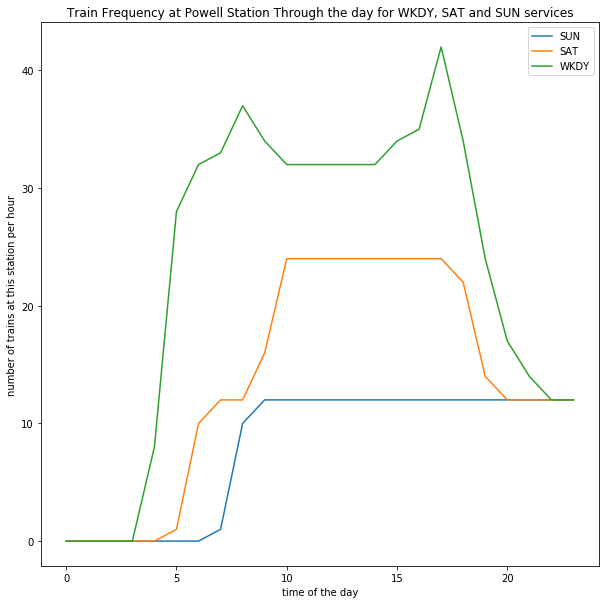

In [385]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
plt.plot(powl_count_SUN)
plt.plot(powl_count_SAT)
plt.plot(powl_count_WKDY)
plt.ylabel('number of trains at this station per hour')
plt.xlabel('time of the day')
plt.legend(['SUN','SAT','WKDY'])
plt.title('Train Frequency at Powell Station Through the day for WKDY, SAT and SUN services')
plt.show()

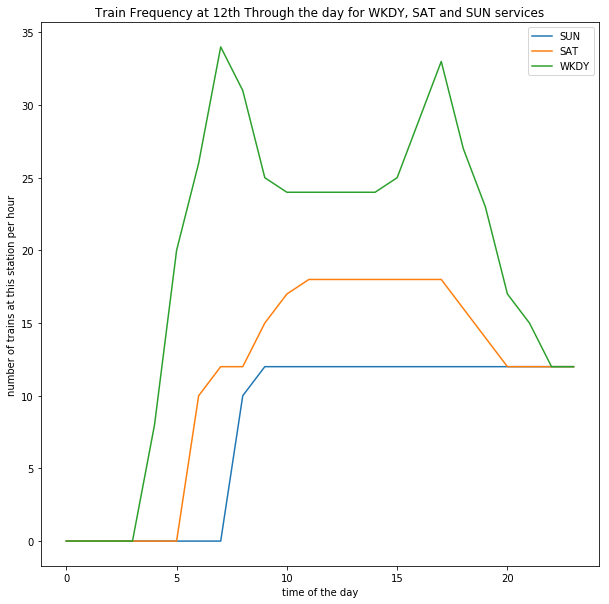

In [395]:
# Similarily,we could conduct the same procedure on other critical stops:
all_stop_tw = pd.merge(stop_times, trips_stoptimes)[stop_times.stop_id == '12TH']
SUN_tw = all_stop_tw[all_stop_tw.service_id == 'SUN']
SAT_tw = all_stop_tw[all_stop_tw.service_id == 'SAT']
WKDY_tw = all_stop_tw[all_stop_tw.service_id == 'WKDY']
twTH_count_SUN = np.zeros(24, dtype = int)
twTH_count_SAT = np.zeros(24, dtype = int)
twTH_count_WKDY = np.zeros(24, dtype = int)
for string in SUN_tw.departure_time.values:
    if int(string[:2]) < 24:
        twTH_count_SUN[int(string[:2])] += 1
for string in SAT_tw.departure_time.values:
    if int(string[:2]) < 24:
        twTH_count_SAT[int(string[:2])] += 1
for string in WKDY_tw.departure_time.values:
    if int(string[:2]) < 24:
        twTH_count_WKDY[int(string[:2])] += 1
fig = plt.figure(figsize=(10,10))
plt.plot(twTH_count_SUN)
plt.plot(twTH_count_SAT)
plt.plot(twTH_count_WKDY)
plt.ylabel('number of trains at this station per hour')
plt.xlabel('time of the day')
plt.legend(['SUN','SAT','WKDY'])
plt.title('Train Frequency at 12th Through the day for WKDY, SAT and SUN services')
plt.show()

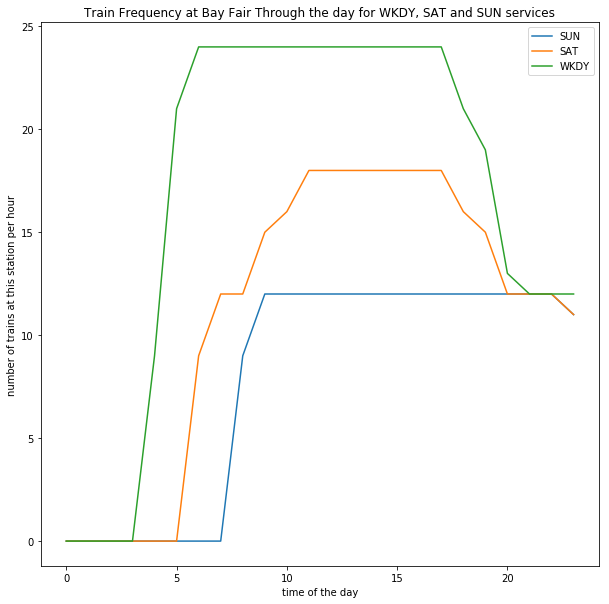

In [397]:
# Similarily,we could conduct the same procedure on other critical stops:
all_stop_BAYF = pd.merge(stop_times, trips_stoptimes)[stop_times.stop_id == 'BAYF']
SUN_BAYF = all_stop_BAYF[all_stop_BAYF.service_id == 'SUN']
SAT_BAYF = all_stop_BAYF[all_stop_BAYF.service_id == 'SAT']
WKDY_BAYF = all_stop_BAYF[all_stop_BAYF.service_id == 'WKDY']
BAYF_count_SUN = np.zeros(24, dtype = int)
BAYF_count_SAT = np.zeros(24, dtype = int)
BAYF_count_WKDY = np.zeros(24, dtype = int)
for string in SUN_BAYF.departure_time.values:
    if int(string[:2]) < 24:
        BAYF_count_SUN[int(string[:2])] += 1
for string in SAT_BAYF.departure_time.values:
    if int(string[:2]) < 24:
        BAYF_count_SAT[int(string[:2])] += 1
for string in WKDY_BAYF.departure_time.values:
    if int(string[:2]) < 24:
        BAYF_count_WKDY[int(string[:2])] += 1
fig = plt.figure(figsize=(10,10))
plt.plot(BAYF_count_SUN)
plt.plot(BAYF_count_SAT)
plt.plot(BAYF_count_WKDY)
plt.ylabel('number of trains at this station per hour')
plt.xlabel('time of the day')
plt.legend(['SUN','SAT','WKDY'])
plt.title('Train Frequency at Bay Fair Through the day for WKDY, SAT and SUN services')
plt.show()

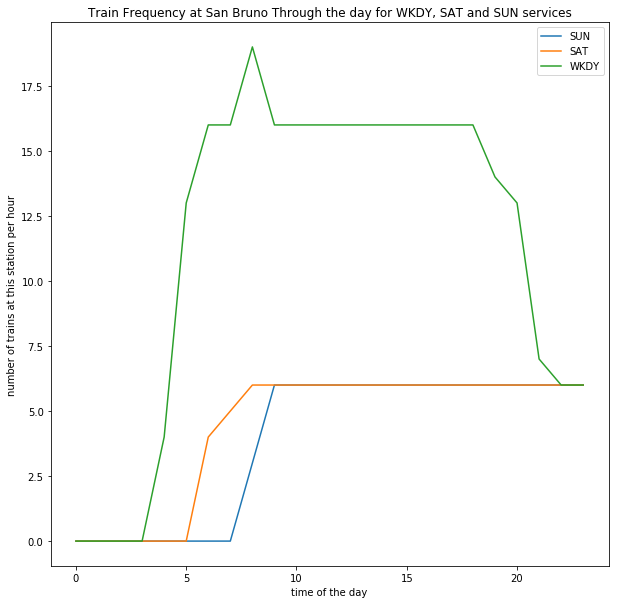

In [399]:
all_stop_SBRN = pd.merge(stop_times, trips_stoptimes)[stop_times.stop_id == 'SBRN']
SUN_SBRN = all_stop_SBRN[all_stop_SBRN.service_id == 'SUN']
SAT_SBRN = all_stop_SBRN[all_stop_SBRN.service_id == 'SAT']
WKDY_SBRN = all_stop_SBRN[all_stop_SBRN.service_id == 'WKDY']
SBRN_count_SUN = np.zeros(24, dtype = int)
SBRN_count_SAT = np.zeros(24, dtype = int)
SBRN_count_WKDY = np.zeros(24, dtype = int)
for string in SUN_SBRN.departure_time.values:
    if int(string[:2]) < 24:
        SBRN_count_SUN[int(string[:2])] += 1
for string in SAT_SBRN.departure_time.values:
    if int(string[:2]) < 24:
        SBRN_count_SAT[int(string[:2])] += 1
for string in WKDY_SBRN.departure_time.values:
    if int(string[:2]) < 24:
        SBRN_count_WKDY[int(string[:2])] += 1
fig = plt.figure(figsize=(10,10))
plt.plot(SBRN_count_SUN)
plt.plot(SBRN_count_SAT)
plt.plot(SBRN_count_WKDY)
plt.ylabel('number of trains at this station per hour')
plt.xlabel('time of the day')
plt.legend(['SUN','SAT','WKDY'])
plt.title('Train Frequency at San Bruno Through the day for WKDY, SAT and SUN services')
plt.show()

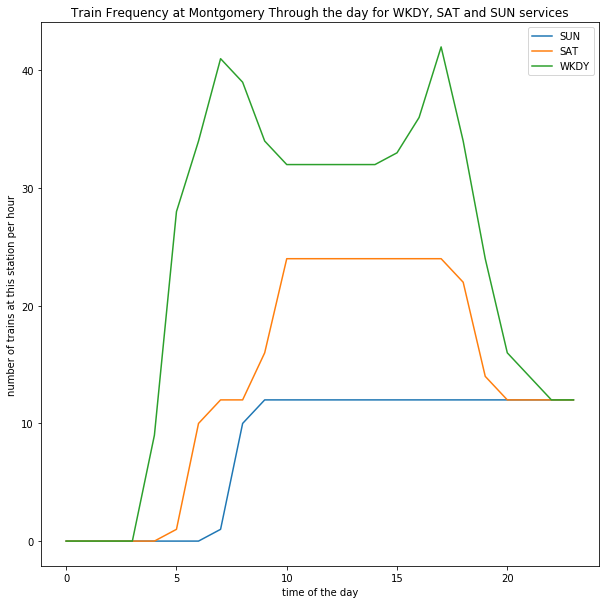

In [400]:
all_stop_MONT = pd.merge(stop_times, trips_stoptimes)[stop_times.stop_id == 'MONT']
SUN_MONT = all_stop_MONT[all_stop_MONT.service_id == 'SUN']
SAT_MONT = all_stop_MONT[all_stop_MONT.service_id == 'SAT']
WKDY_MONT = all_stop_MONT[all_stop_MONT.service_id == 'WKDY']
MONT_count_SUN = np.zeros(24, dtype = int)
MONT_count_SAT = np.zeros(24, dtype = int)
MONT_count_WKDY = np.zeros(24, dtype = int)
for string in SUN_MONT.departure_time.values:
    if int(string[:2]) < 24:
        MONT_count_SUN[int(string[:2])] += 1
for string in SAT_MONT.departure_time.values:
    if int(string[:2]) < 24:
        MONT_count_SAT[int(string[:2])] += 1
for string in WKDY_MONT.departure_time.values:
    if int(string[:2]) < 24:
        MONT_count_WKDY[int(string[:2])] += 1
fig = plt.figure(figsize=(10,10))
plt.plot(MONT_count_SUN)
plt.plot(MONT_count_SAT)
plt.plot(MONT_count_WKDY)
plt.ylabel('number of trains at this station per hour')
plt.xlabel('time of the day')
plt.legend(['SUN','SAT','WKDY'])
plt.title('Train Frequency at Montgomery Through the day for WKDY, SAT and SUN services')
plt.show()

From these plots we could notice that shapes of train frequencies at these stops are approximately the same, there are few points raise my interests:<br>
1. There is a peak frequency in the morning and evening rush hours for weekday services.<br>
2. The starting service time for weekday is earlier than that of Saturday services and Sunday services, but they tend to end roughly same time at the end of day.
3. According to the peak frequencies of peak hours, the busiest level is Powell Street > Montgomery > 12th Street > Bay Fair > San Bruno. This is different from the PageRank ranking sequence, and also differ from Hits ranking.

# Task 2: Compare the frequency between weekdays and weekends.

In [529]:
# We can see how many trips on a weekday, saturday and sunday
merged = pd.merge(stop_times, trips)
WeekdayTrips = merged[merged.service_id == 'WKDY']
num_WeekdayTrips = len(WeekdayTrips.trip_id.unique())
print('number of trips on a normal weekday is '+str(num_WeekdayTrips))
SatTrips = merged[merged.service_id == 'SAT']
num_SatTrips = len(SatTrips.trip_id.unique())
print('number of trips on a normal Saturday is '+str(num_SatTrips))
SunTrips = merged[merged.service_id == 'SUN']
num_SunTrips = len(SunTrips.trip_id.unique())
print('number of trips on a normal Sunday is '+str(num_SunTrips))

number of trips on a normal weekday is 1113
number of trips on a normal Saturday is 800
number of trips on a normal Sunday is 612


We could compare the frequency of trips/trains happenend during each hour of the day for the Weekday, Saturday and Sunday service:

In [459]:
# One way to define the happening of a trip is to find out the departure time of first stop
WeekdayTrips = WeekdayTrips[WeekdayTrips.stop_sequence == 1]
SatTrips = SatTrips[SatTrips.stop_sequence == 1]
SunTrips = SunTrips[SunTrips.stop_sequence == 1]
WeekdayTrips

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,route_id,service_id,trip_headsign,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed
2952,3610403WKDY,03:49:00,03:49:00,ANTC,1,San Francisco International Airport,NaN,NaN,NaN,1,1,WKDY,San Francisco International Airport,0,NaN,01_shp,1,1
2979,3630418WKDY,04:04:00,04:04:00,ANTC,1,San Francisco International Airport,NaN,NaN,NaN,1,1,WKDY,San Francisco International Airport,0,NaN,01_shp,1,1
3006,3650433WKDY,04:19:00,04:19:00,ANTC,1,San Francisco International Airport,NaN,NaN,NaN,1,1,WKDY,San Francisco International Airport,0,NaN,01_shp,1,1
3033,3670448WKDY,04:34:00,04:34:00,ANTC,1,San Francisco International Airport,NaN,NaN,NaN,1,1,WKDY,San Francisco International Airport,0,NaN,01_shp,1,1
3060,3690503WKDY,04:49:00,04:49:00,ANTC,1,San Francisco International Airport,NaN,NaN,NaN,1,1,WKDY,San Francisco International Airport,0,NaN,01_shp,1,1
3087,3710518WKDY,05:04:00,05:04:00,ANTC,1,San Francisco International Airport,NaN,NaN,NaN,1,1,WKDY,San Francisco International Airport,0,NaN,01_shp,1,1
3114,3730533WKDY,05:19:00,05:19:00,ANTC,1,San Francisco International Airport,NaN,NaN,NaN,1,1,WKDY,San Francisco International Airport,0,NaN,01_shp,1,1
3141,3750548WKDY,05:34:00,05:34:00,ANTC,1,San Francisco International Airport,NaN,NaN,NaN,1,1,WKDY,San Francisco International Airport,0,NaN,01_shp,1,1
3168,3210613WKDY,06:13:00,06:13:00,PHIL,1,Montgomery St.,NaN,NaN,NaN,1,1,WKDY,Montgomery St.,0,NaN,01_shp,1,1
3179,3770603WKDY,05:49:00,05:49:00,ANTC,1,San Francisco International Airport,NaN,NaN,NaN,1,1,WKDY,San Francisco International Airport,0,NaN,01_shp,1,1


In [457]:
# Initialize an array to store the number of trips within this hour:
weekday_tripcount = np.zeros(24)
for string in WeekdayTrips.departure_time.values:
    if int(string[:2]) < 24:
        weekday_tripcount[int(string[:2])] += 1
weekday_tripcount

array([  0.,   0.,   0.,   2.,  38.,  63.,  67.,  69.,  64.,  60.,  60.,
        60.,  60.,  61.,  60.,  63.,  67.,  68.,  57.,  44.,  40.,  40.,
        38.,  23.])

In [462]:
sat_tripcount = np.zeros(24)
for string in SatTrips.departure_time.values:
    if int(string[:2]) < 24:
        sat_tripcount[int(string[:2])] += 1
sat_tripcount

array([  0.,   0.,   0.,   0.,   0.,   6.,  41.,  38.,  40.,  46.,  50.,
        50.,  50.,  50.,  50.,  50.,  50.,  50.,  44.,  38.,  38.,  38.,
        38.,  24.])

In [463]:
sun_tripcount = np.zeros(24)
for string in SunTrips.departure_time.values:
    if int(string[:2]) < 24:
        sun_tripcount[int(string[:2])] += 1
sun_tripcount

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   6.,  41.,  38.,  38.,
        38.,  38.,  38.,  38.,  38.,  38.,  38.,  38.,  38.,  38.,  38.,
        38.,  24.])

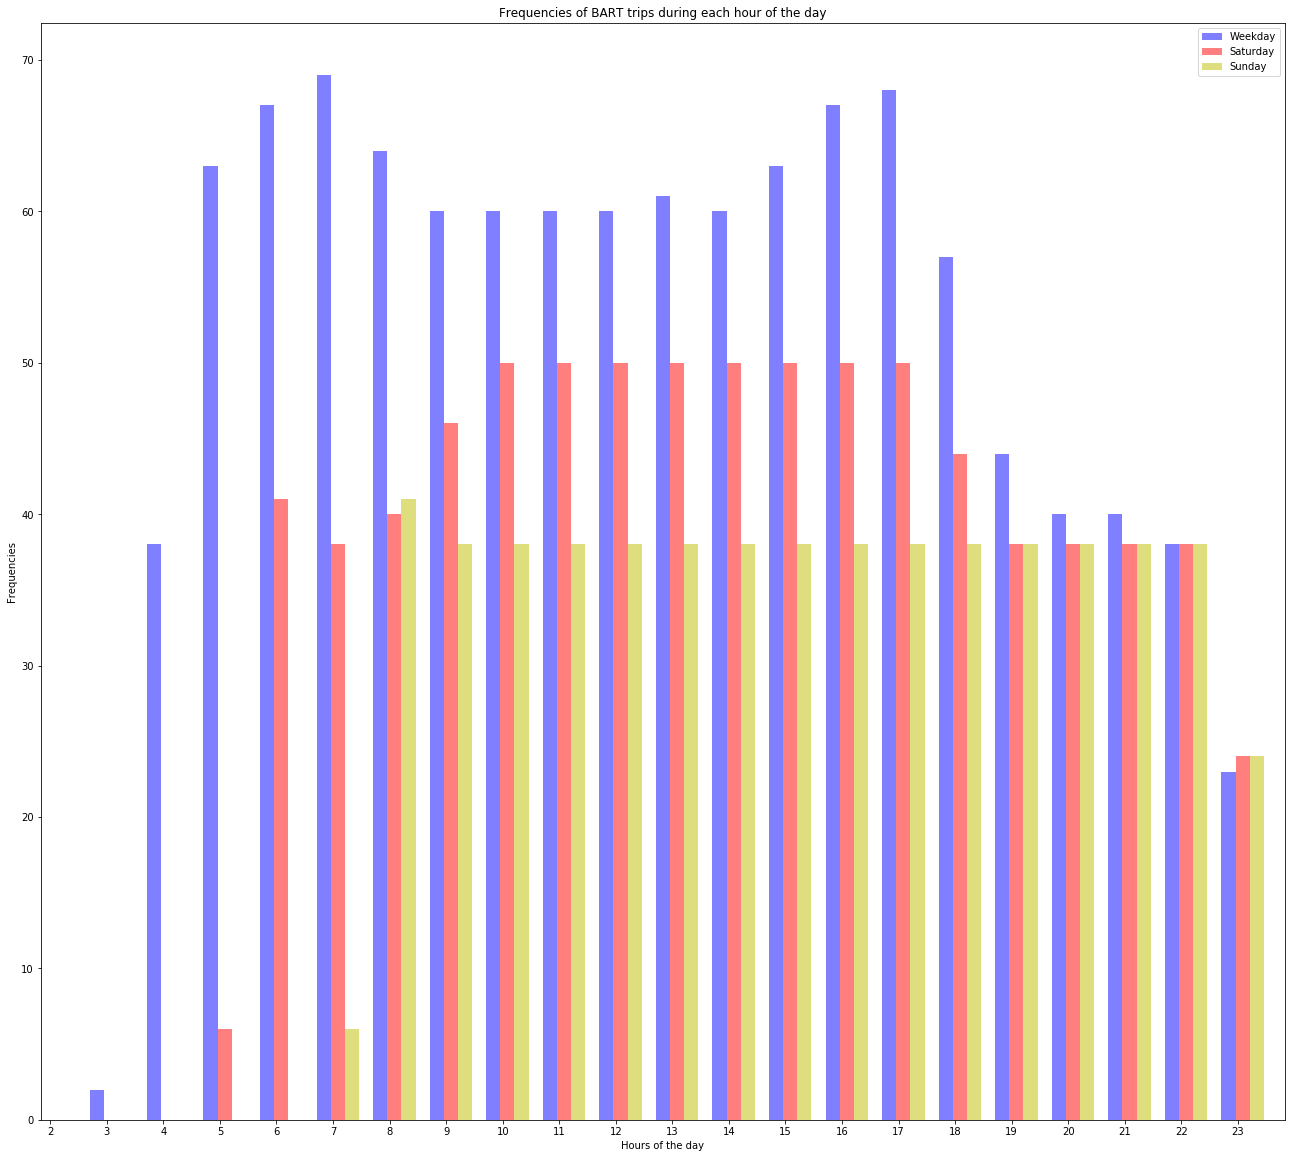

In [515]:
fig, ax = plt.subplots()
index = np.arange(24)
bar_width = 0.25
opacity = 0.5
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, weekday_tripcount, bar_width,
                alpha=opacity, color='b',
                label='Weekday')
rects2 = ax.bar(index + bar_width, sat_tripcount, bar_width,
                alpha=opacity, color='r',
                label='Saturday')
rects3 = ax.bar(index + bar_width*2, sun_tripcount, bar_width,
                alpha=opacity, color='y',
                label='Sunday')
ax.set_xlabel('Hours of the day')
ax.set_ylabel('Frequencies')
ax.set_title('Frequencies of BART trips during each hour of the day')
ax.set_xticks(index + bar_width / 1.5)
ax.set_xticklabels(index)
ax.legend()
fig.tight_layout()
plt.xlim(2,24)
this_plot = plt.gcf()
this_plot.set_size_inches(20, 20)
plt.show()

From this bartchart diagram, we could see that:<br>
1. the number of weekday trips overnumber both that of Saturday's service and Sunday's service.
2. Weekday service covers more early morning hours when Saturday and Sunday service do not cover.
3. The number of trips happened after 18:00 count almost the same for three services.
4. For the daytime, i.e 9:00 - 18:00, the number of trips happened for Saturday is the average of that of Sunday's and Weekday's service.

# Task 3: Explain how passenger count and flow densities were obtained

Speaking of the passenger count, the ticket gates of each stop would precisely count the number of passengers entering this stop and how many exit from this stop. If we manage to get the count of passengers swiped into the BART system, either buying tickets or using rapid transit pass, minus the number of swiped out, we could have a precise count of how many passengers are currently using BART services.


In fact, BART has this monthly ridership report from its website: https://www.bart.gov/about/reports/ridershipM<br>

In [528]:
ridership = pd.read_csv('Ridership_201801.csv')
# Drop all NaN data entries
ridership = ridership.dropna(axis = 1, how='all')
ridership.dropna(axis = 0, how = "all")
# And we can see that the number of passengers entried = number of passengers exited

,Unnamed: 0,RM,EN,EP,NB,BK,AS,MA,19,12,...,NC,WP,SS,SB,SO,MB,WD,OA,WS,Exits
0,RM,13,109,82,65,366,102,138,149,180,...,2,35,12,19,59,27,8,12,7,"3,935"
1,EN,132,20,91,96,826,139,262,471,562,...,6,27,34,43,114,71,13,31,26,"8,247"
2,EP,86,81,13,47,659,83,134,298,336,...,4,11,10,11,60,32,7,25,11,"4,702"
3,NB,72,87,51,16,200,61,91,285,249,...,3,16,8,10,91,36,8,31,17,"4,396"
4,BK,406,897,668,208,36,361,362,562,528,...,49,113,34,39,180,139,49,74,78,"11,123"
5,AS,105,128,83,61,329,15,83,264,252,...,7,28,13,14,64,42,10,23,22,"5,086"
6,MA,154,268,121,87,351,84,42,196,228,...,63,260,31,31,109,68,27,27,34,"8,692"
7,19,163,478,302,291,513,262,190,30,59,...,173,281,69,72,89,135,106,35,110,"12,962"
8,12,203,584,324,253,454,240,224,56,37,...,174,343,89,84,125,157,123,45,88,"13,331"
9,LM,36,84,60,45,213,62,58,44,42,...,11,53,12,15,37,19,77,19,92,"6,524"


By the definition of traffic flow from https://en.wikipedia.org/wiki/Traffic_flow, traffic flow: q = k*v, where k represents the density and v represents the velocity.<br>
1. In a normal traffic senario, the density refers to number of vehicles in a unit length of distance. Hence, we could refer the density here as average number of passengers(passenger count) on BART trains in the distance of a mile in a running BART system. Notice we have a passenger count, ideally the total number of passengers riding all running trains at a certain timestamp, we simply divide that by the total railway length and we could get the density at that timestamp. <br>
2. Velocity would be the average velocity of a bart train when it is running a service. Notice here we are not talking about the marching speed when it is on the railway. An easy way to calculate the average velocity of a bart train is we divide the railway length by the time for this trip, which will take into account of the acceleration/decceleration into/out of stops, stop times, boarding and alighting time.<br>

Now we have density and velocity, we could estimate the passenger flow at any timestamp by q = k*v

# Task 4: Explain with frequency plots on how 12th St Oakland station compares with the other 4 critical stations at different times of the day.

For this task, I would like to have the train frequency for 5 critical stations during each hours of the day:

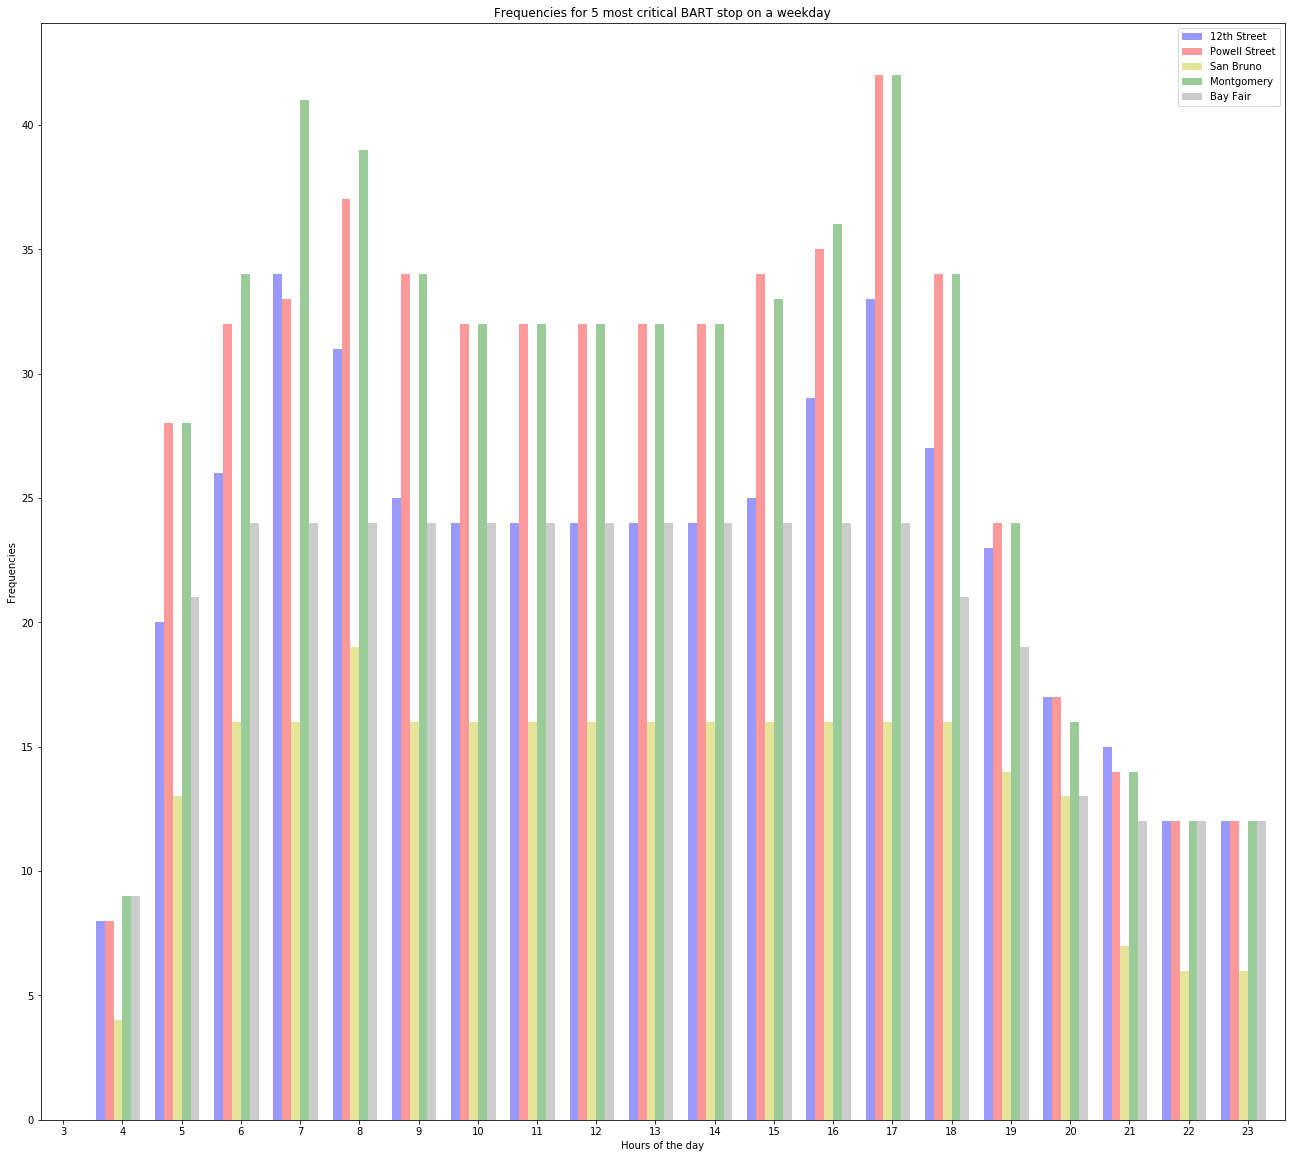

In [508]:
# For Weekday service:
fig, ax = plt.subplots()
index = np.arange(24)
bar_width = 0.15
opacity = 0.4
error_config = {'ecolor': '0.3'}
rects1 = ax.bar(index, twTH_count_WKDY, bar_width,
                alpha=opacity, color='b',
                label='12th Street')
rects2 = ax.bar(index+bar_width, powl_count_WKDY, bar_width,
                alpha=opacity, color='r',
                label='Powell Street')
rects3 = ax.bar(index+bar_width*2, SBRN_count_WKDY, bar_width,
                alpha=opacity, color='y',
                label='San Bruno')
rects4 = ax.bar(index+bar_width*3, MONT_count_WKDY, bar_width,
                alpha=opacity, color='g',
                label='Montgomery')
rects5 = ax.bar(index+bar_width*4, BAYF_count_WKDY, bar_width,
                alpha=opacity, color='gray',
                label='Bay Fair')
ax.set_xlabel('Hours of the day')
ax.set_ylabel('Frequencies')
ax.set_title('Frequencies for 5 most critical BART stop on a weekday')
ax.set_xticks(index + bar_width*2.5)
ax.set_xticklabels(index)

ax.legend()
fig.tight_layout()
# Enlarge vision by resetting the limit for x-axis
plt.xlim(3,24)
this_plot = plt.gcf()
this_plot.set_size_inches(20, 20)
plt.show()

Analyzing the train arriving/departure frequency plot for the most 5 critical BART stop on a weekday:<br>
1. The train arriving/departure frequencies for Powell Street and Montgomery Street are the same since they are geographically next to each other and all trips through Powell Street will also be through Montgomery Street.
2. San Bruno has least frequency of training arriving/departure among these five stops.
3. 12th Street has roughly the same frequencies as Bay Fair. From the perspective of routes, they are both 3 routes even though they only share one route: Richmond - South Fremont. Which means the frequencies of trips for the sum of two sets of their independent routes sum up to almost same number for a normal weekday.

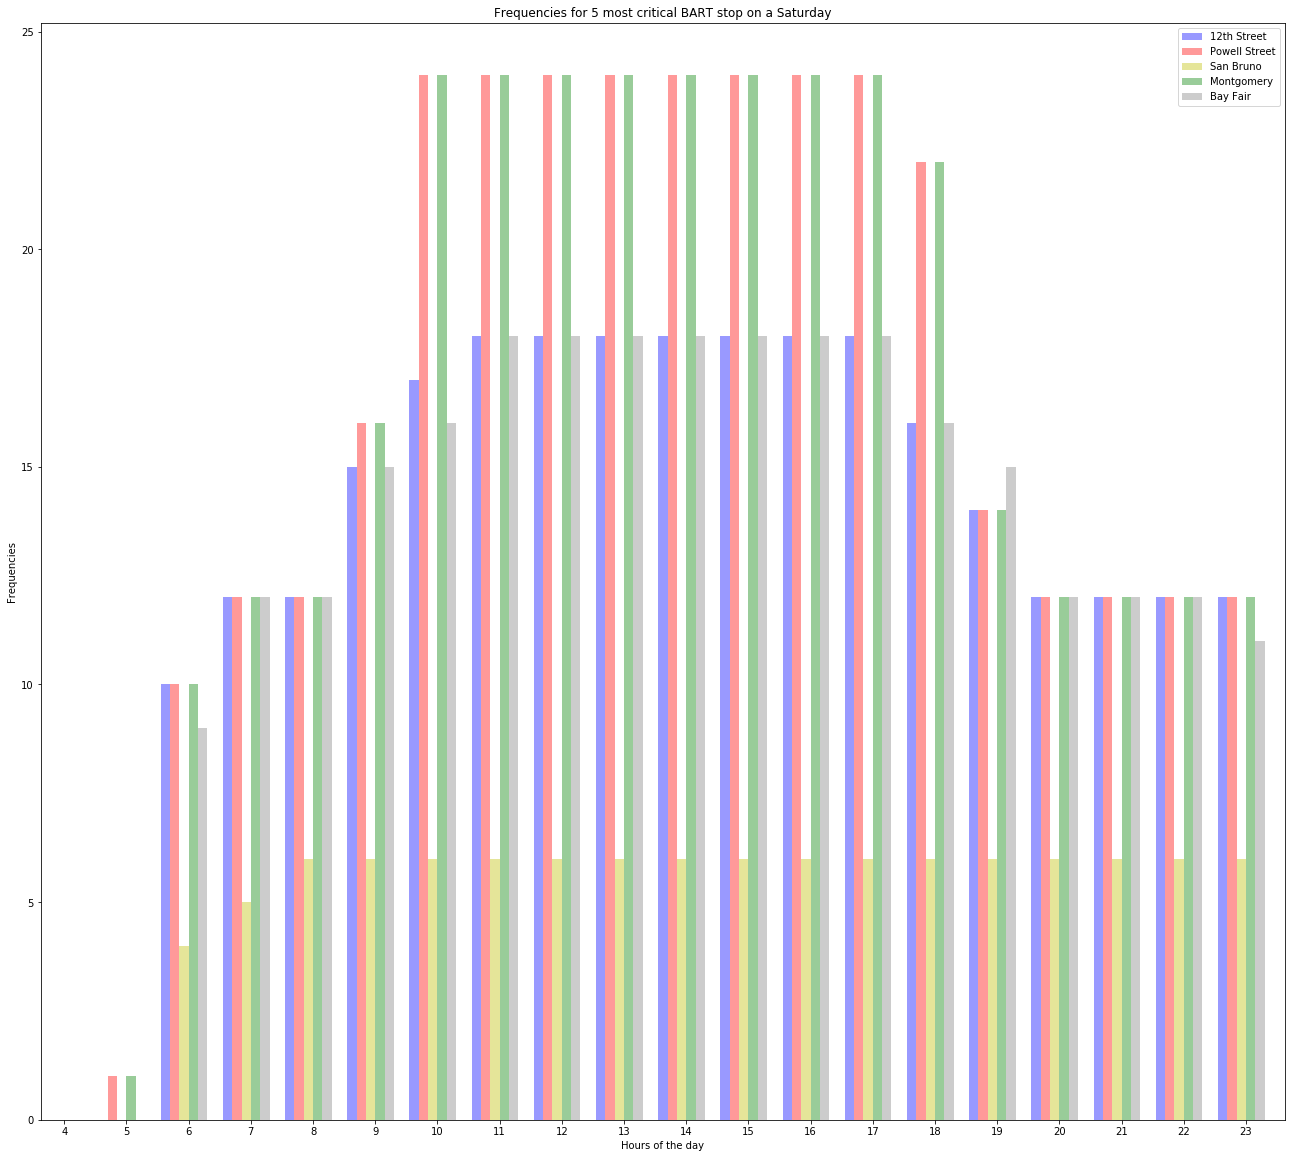

In [517]:
# For Saturday Service:
fig, ax = plt.subplots()
index = np.arange(24)
bar_width = 0.15
opacity = 0.4
error_config = {'ecolor': '0.3'}
rects1 = ax.bar(index, twTH_count_SAT, bar_width,
                alpha=opacity, color='b',
                label='12th Street')
rects2 = ax.bar(index+bar_width, powl_count_SAT, bar_width,
                alpha=opacity, color='r',
                label='Powell Street')
rects3 = ax.bar(index+bar_width*2, SBRN_count_SAT, bar_width,
                alpha=opacity, color='y',
                label='San Bruno')
rects4 = ax.bar(index+bar_width*3, MONT_count_SAT, bar_width,
                alpha=opacity, color='g',
                label='Montgomery')
rects5 = ax.bar(index+bar_width*4, BAYF_count_SAT, bar_width,
                alpha=opacity, color='gray',
                label='Bay Fair')
ax.set_xlabel('Hours of the day')
ax.set_ylabel('Frequencies')
ax.set_title('Frequencies for 5 most critical BART stop on a Saturday')
ax.set_xticks(index + bar_width*2.5)
ax.set_xticklabels(index)

ax.legend()
fig.tight_layout()
plt.xlim(4, 24)
this_plot = plt.gcf()
this_plot.set_size_inches(20, 20)
plt.show()

1. For a normal Saturday, the majority number of trips happen between 9:00 to 19:0.
2. The frequencies for 12th Street and Bay Fair are exactly the same, meaning the BART authorities are determining that the flow for routes passing through them are equal for Saturday Services.

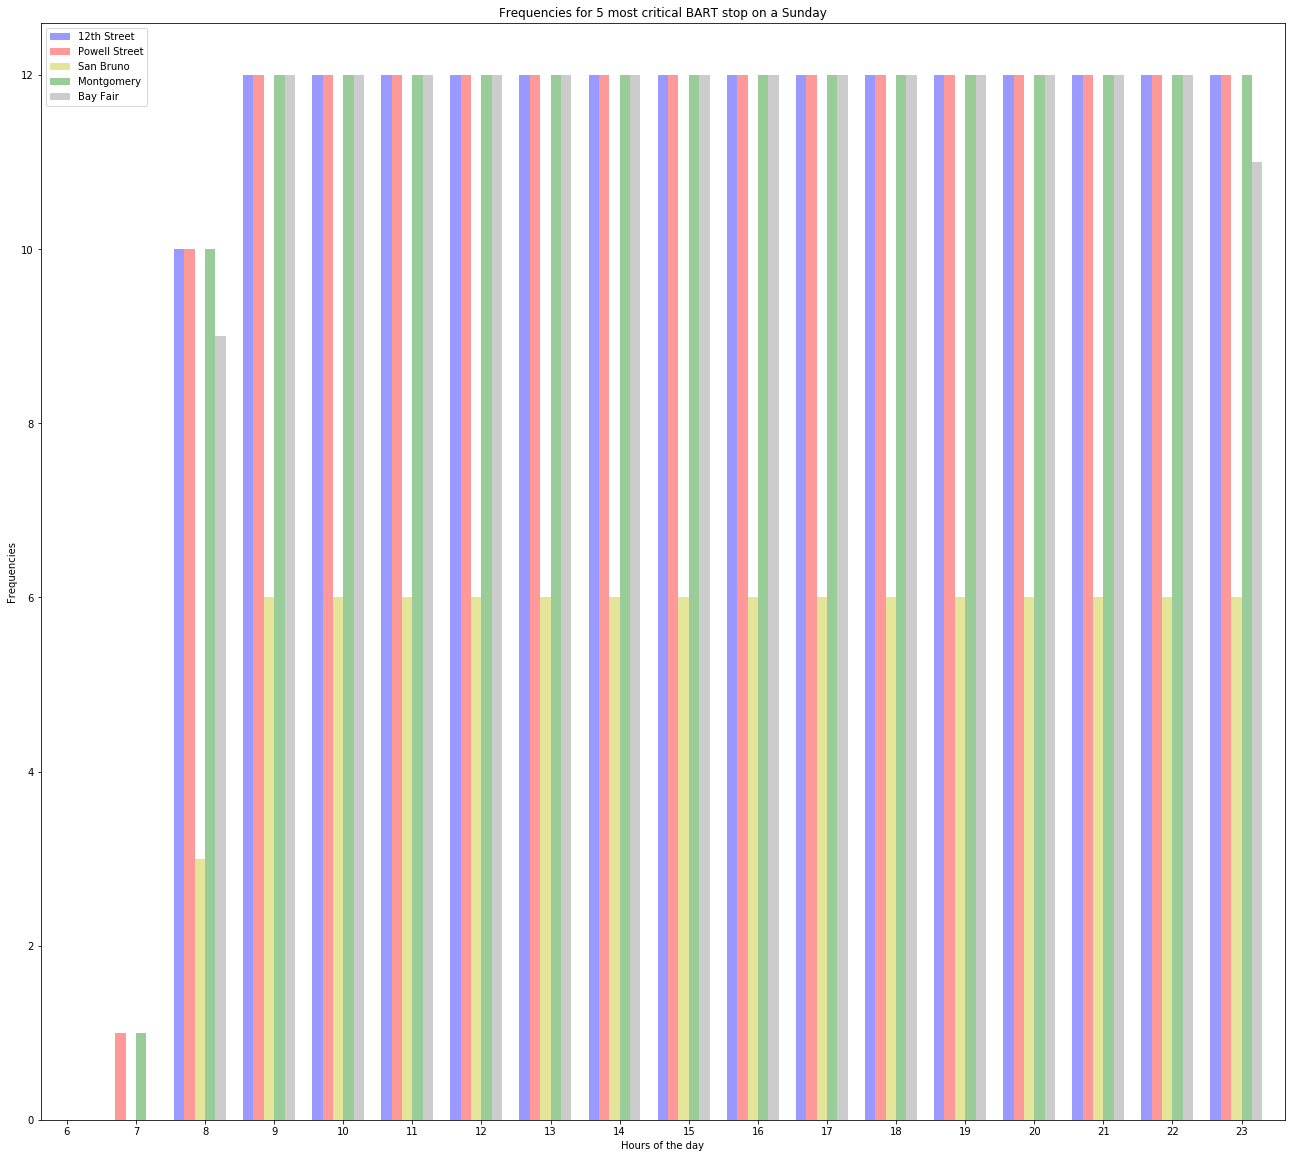

In [512]:
# For Sunday Service:
fig, ax = plt.subplots()
index = np.arange(24)
bar_width = 0.15
opacity = 0.4
error_config = {'ecolor': '0.3'}
rects1 = ax.bar(index, twTH_count_SUN, bar_width,
                alpha=opacity, color='b',
                label='12th Street')
rects2 = ax.bar(index+bar_width, powl_count_SUN, bar_width,
                alpha=opacity, color='r',
                label='Powell Street')
rects3 = ax.bar(index+bar_width*2, SBRN_count_SUN, bar_width,
                alpha=opacity, color='y',
                label='San Bruno')
rects4 = ax.bar(index+bar_width*3, MONT_count_SUN, bar_width,
                alpha=opacity, color='g',
                label='Montgomery')
rects5 = ax.bar(index+bar_width*4, BAYF_count_SUN, bar_width,
                alpha=opacity, color='gray',
                label='Bay Fair')
ax.set_xlabel('Hours of the day')
ax.set_ylabel('Frequencies')
ax.set_title('Frequencies for 5 most critical BART stop on a Sunday')
ax.set_xticks(index + bar_width*2.5)
ax.set_xticklabels(index)

ax.legend()
fig.tight_layout()
plt.xlim(6,24)
this_plot = plt.gcf()
this_plot.set_size_inches(20, 20)
plt.show()

For a Sunday Service, we notice that the frequency for 12th Street, Powell Street, Montgomery and Bay Fair are the same. The BART authority make this decision because figure out that people are flowing equally into the city and to east bay.